In [157]:
import pandas as pd
import numpy as np
import glob
import os
import json
from tqdm import tqdm_notebook

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, Callback
from keras.constraints import min_max_norm

# 1. load data

In [158]:
TRAIN_PATH = './Desktop/data-2/train'
train_filepaths = sorted(glob.glob(os.path.join(TRAIN_PATH, '*.csv')))
train_filepaths = {int(os.path.splitext(os.path.basename(filepath))[0]):filepath for filepath in train_filepaths}
print('The number of train files is: %i' % len(train_filepaths))

The number of train files is: 11


In [159]:
train_filepaths

{1: './Desktop/data-2/train/1.csv',
 10: './Desktop/data-2/train/10.csv',
 11: './Desktop/data-2/train/11.csv',
 12: './Desktop/data-2/train/12.csv',
 2: './Desktop/data-2/train/2.csv',
 29: './Desktop/data-2/train/29.csv',
 3: './Desktop/data-2/train/3.csv',
 31: './Desktop/data-2/train/31.csv',
 32: './Desktop/data-2/train/32.csv',
 4: './Desktop/data-2/train/4.csv',
 7: './Desktop/data-2/train/7.csv'}

In [160]:
train_dfs = {key: pd.read_csv(train_filepaths[key],delimiter=';') for key in tqdm_notebook(train_filepaths)}

/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [161]:
train_dfs

{1:                        timestamp  site_id  period_id  actual_consumption  \
 0      2014-08-06T09:30:00+03:00        1          1        59181.237456   
 1      2014-08-06T09:45:00+03:00        1          1        52179.319490   
 2      2014-08-06T10:00:00+03:00        1          1        61116.525719   
 3      2014-08-06T10:15:00+03:00        1          1        60876.659230   
 4      2014-08-06T10:30:00+03:00        1          1        67396.244798   
 ...                          ...      ...        ...                 ...   
 38395  2017-10-22T20:15:00+03:00        1         10        54280.550734   
 38396  2017-10-22T20:30:00+03:00        1         10        54341.917044   
 38397  2017-10-22T20:45:00+03:00        1         10        53581.586663   
 38398  2017-10-22T21:00:00+03:00        1         10        53664.548156   
 38399  2017-10-22T21:15:00+03:00        1         10        54479.206416   
 
           actual_pv       load_00       load_01       load_02       lo

### divide the train set into periods.

In [162]:
def get_train_samples(train_dfs):
    train_samples = {key: [] for key in train_dfs}
    for key in tqdm_notebook(train_dfs):
        df = train_dfs[key]
        _period_ids = sorted(df.period_id.unique())#得到每个csv文件中的不重复的period id
        for period_id in _period_ids:
            df_period = df[df.period_id == period_id].copy()#将每个csv文件按period id存到df_period中
            df_period.reset_index(drop=True, inplace=True)
            train_samples[key].append(df_period)
    return train_samples

In [183]:
train_samples = get_train_samples(train_dfs)
#需要这个函数是因为每个train dataset，也就是每个csv文件中的时间是不连续的，1个period等于10天
#因此使用这个函数对每个csv文件按period进行分类
train_samples

/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


{1: [                      timestamp  site_id  period_id  actual_consumption  \
  0     2014-08-06T09:30:00+03:00        1          1        59181.237456   
  1     2014-08-06T09:45:00+03:00        1          1        52179.319490   
  2     2014-08-06T10:00:00+03:00        1          1        61116.525719   
  3     2014-08-06T10:15:00+03:00        1          1        60876.659230   
  4     2014-08-06T10:30:00+03:00        1          1        67396.244798   
  ...                         ...      ...        ...                 ...   
  3835  2014-08-06T08:15:00+03:00        1          1        51232.870631   
  3836  2014-08-06T08:30:00+03:00        1          1        52048.428690   
  3837  2014-08-06T08:45:00+03:00        1          1        56615.789773   
  3838  2014-08-06T09:00:00+03:00        1          1        51465.518730   
  3839  2014-08-06T09:15:00+03:00        1          1        54100.170974   
  
           actual_pv       load_00       load_01       load_02       l

# 2. prepare data
* the metrics is the difference between actual consumption and load_00, didnt compare other forecasted value, accuracy may change(get worse) if we include other forecasted value

In [164]:
# prepare_data_for_fitting(train_samples[site_id][:n_periods])
# [:n_periods]是为了有validation set
# 这个函数主要做的就是：对每个site的每个period的数据进行分组之后，建立特征和要预测的值
def prepare_data_for_fitting(df_list, n_forecasts=10, real_column='actual_consumption', forecast_key='load_'):
    # n_forecasts : 
    x, y = [], []
    for df in df_list:#一次取一个period,因为传进来的数据是train_samples[site_id][:n_periods]，表示会有n_periods的数据传进来
        real_value = df.loc[n_forecasts:, 'actual_consumption']
        
        features = np.zeros((n_forecasts, len(real_value)))
        #下面的两个循环做的就是使用

        for i in range(1):
            start = n_forecasts - i - 1
            end = len(df)-i -2
            features[i] = df.loc[start:end, 'load_%02d' % (i)].values
            
        for i in range(n_forecasts-1):
            start = n_forecasts - i - 1#feature 0和feature 1开始的地方一样
            end = len(df)-i -2
            features[i+1] = df.loc[start:end, 'actual_consumption'].values# - df.loc[start:end, 'actual_pv'].values
        #有start和end的情况下，如何跟real_values保持同一个横向的维度？因为real values是从n_forecasts开始的
        
        x.append(features)
        y.append(real_value)
    x = np.concatenate(x, axis=1)#当有多个period时候x里面就是由多个period的数据组成的特征
    x = np.transpose(x, axes=(1, 0))
    y = np.concatenate(y, axis=0)
    return x, y

In [165]:
def metric(demand, forecast):
    return np.mean(np.abs(demand-forecast))

In [166]:
#need to change something aboout the metrics

# 3. version 1 : linear regression
## 3.1 traning of the model:

In [167]:
class ModelCheckpointRAM(Callback):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
         monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.epochs_since_last_save = 0
        self.weights = None

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0            
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can save best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                              ' saving model'
                              % (epoch, self.monitor, self.best, current))
                    self.best = current
                    self.weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('Epoch %05d: %s did not improve' %
                              (epoch, self.monitor))

In [168]:
def multiple_train_for_all_sites(n_columns):
#n_columns : 从生成的特征里面选择n_columns列
    df = pd.DataFrame(columns=['site_id', 'n_periods', 'timestamp', 'train_baseline', 'train_loss',
                               'val_baseline', 'val_loss', 'train_gain', 'val_gain', 'coef'])
    i = 0
    for site_id in tqdm_notebook(train_samples):#train_samples是个字典，根据字典的key进行循环，在这里key的数值代表site_id
        total_periods = len(train_samples[site_id])#每个site有不同的period，total_periods得到每个site有几个period
        for period_idx in tqdm_notebook(range(total_periods-1), total=total_periods-1, leave=False):
            n_periods = period_idx + 1#total_periods-1是为了留一个当作validation

            x_train, y_train = prepare_data_for_fitting(train_samples[site_id][:n_periods])#为什么是:n_periods，而不是n_periods？
            x_val, y_val = prepare_data_for_fitting(train_samples[site_id][n_periods:])

            x_train = x_train[:, :n_columns]
            x_val = x_val[:, :n_columns]


            model = Sequential()
            model.add(Dense(1, input_shape=(n_columns,), bias_constraint=min_max_norm(0, 0)))

            n_repeat = int(40000/len(y_train))#为什么repeat？
            if n_repeat > 0:
                x_train = np.repeat(x_train, n_repeat, axis=0)
                y_train = np.repeat(y_train, n_repeat, axis=0)

            model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=[])
            callbacks = [
                EarlyStopping(patience=10, mode='min'),
                ModelCheckpointRAM(mode='min')
            ]
            ret = model.fit(x=x_train, y=y_train, batch_size=int(2**10), epochs=20000,
                            callbacks=callbacks,
                            validation_data=(x_val, y_val), verbose=0,)
            model.set_weights(callbacks[1].weights)

            train_baseline = metric(x_train[:, 0], y_train)
            val_baseline = metric(x_val[:, 0], y_val)
            train_loss = np.min(ret.history['loss'])
            val_loss = np.min(ret.history['val_loss'])
            train_gain = (train_baseline - train_loss)/train_baseline
            val_gain = (val_baseline - val_loss)/val_baseline

            coef = model.get_weights()[0][:, 0].astype(np.float64).round(4).tolist()
            timestamp = train_samples[site_id][period_idx].timestamp.values[-1]
            #取每个site的每个period的最后一个timestamp
            #为什么是timestamp

            df.loc[i] = [site_id, n_periods, timestamp, train_baseline, train_loss, val_baseline, 
                         val_loss, train_gain, val_gain, coef]
            i += 1

    
    print('Mean train gain: %.3f' % df.mean()['train_gain'])
    print('Mean val gain: %.3f' % df.mean()['val_gain'])
    return df

df = multiple_train_for_all_sites(2)
df

/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Mean train gain: 0.038
Mean val gain: 0.036


,site_id,n_periods,timestamp,train_baseline,train_loss,val_baseline,val_loss,train_gain,val_gain,coef
0,1,1,2014-08-06T09:15:00+03:00,2704.040149,2671.259694,1333.044692,1312.898654,0.012123,0.015113,"[0.7538, 0.2465]"
1,1,2,2015-05-02T21:15:00+03:00,2003.794506,1966.476389,1336.731671,1315.401509,0.018624,0.015957,"[0.7775, 0.223]"
2,1,3,2015-08-25T21:15:00+03:00,1775.258506,1769.384370,1339.380980,1302.915409,0.003309,0.027226,"[0.8024, 0.1982]"
3,1,4,2015-10-24T21:15:00+03:00,1678.451831,1702.044233,1331.272509,1278.605741,-0.014056,0.039561,"[0.7458, 0.2547]"
4,1,5,2016-02-18T21:15:00+03:00,1638.355663,1676.043081,1301.932813,1231.252549,-0.023003,0.054289,"[0.699, 0.3014]"
...,...,...,...,...,...,...,...,...,...,...
104,7,5,2016-02-15T19:15:00+03:00,113.621228,110.240786,111.468969,107.463590,0.029752,0.035933,"[0.6175, 0.3843]"
105,7,6,2016-04-15T19:15:00+03:00,118.588098,116.099720,103.480599,98.410661,0.020983,0.048994,"[0.5571, 0.4476]"
106,7,7,2016-06-14T19:15:00+03:00,119.037464,115.757756,97.396247,92.809547,0.027552,0.047093,"[0.5965, 0.4083]"
107,7,8,2016-08-06T07:15:00+03:00,111.355998,107.744741,117.301501,113.272390,0.032430,0.034348,"[0.7294, 0.274]"


In [169]:
df.groupby('site_id').mean()

,train_baseline,train_loss,val_baseline,val_loss,train_gain,val_gain
site_id,,,,,,
1,1780.291895,1793.281670,1274.218970,1216.360756,-0.009656,0.046356
2,4866.437040,4531.623701,4663.614317,4507.555354,0.068617,0.033377
3,735.937357,713.167249,805.295483,778.733034,0.030989,0.032912
4,982.896655,976.723718,979.598588,965.321442,0.006303,0.014644
7,107.548630,103.297497,112.626546,111.446093,0.041825,0.011677
10,4410.568194,4000.086609,4755.036533,4399.140778,0.093023,0.074935
11,4833.849039,4465.417522,4993.608274,4684.273347,0.076544,0.062088
12,102.651429,97.036213,109.484692,102.022379,0.055365,0.068816
29,1286.480752,1275.321780,1305.749922,1291.997340,0.008646,0.010389


In [170]:
df.groupby('site_id').mean().mean()

train_baseline    2296.613853
train_loss        2168.053413
val_baseline      2243.498955
val_loss          2145.184983
train_gain           0.041476
val_gain             0.035211
dtype: float64

In [171]:
df.head(10)

,site_id,n_periods,timestamp,train_baseline,train_loss,val_baseline,val_loss,train_gain,val_gain,coef
0,1,1,2014-08-06T09:15:00+03:00,2704.040149,2671.259694,1333.044692,1312.898654,0.012123,0.015113,"[0.7538, 0.2465]"
1,1,2,2015-05-02T21:15:00+03:00,2003.794506,1966.476389,1336.731671,1315.401509,0.018624,0.015957,"[0.7775, 0.223]"
2,1,3,2015-08-25T21:15:00+03:00,1775.258506,1769.384370,1339.380980,1302.915409,0.003309,0.027226,"[0.8024, 0.1982]"
3,1,4,2015-10-24T21:15:00+03:00,1678.451831,1702.044233,1331.272509,1278.605741,-0.014056,0.039561,"[0.7458, 0.2547]"
4,1,5,2016-02-18T21:15:00+03:00,1638.355663,1676.043081,1301.932813,1231.252549,-0.023003,0.054289,"[0.699, 0.3014]"
5,1,6,2016-04-04T17:15:00+03:00,1600.868479,1650.697017,1274.057877,1194.131286,-0.031126,0.062734,"[0.6497, 0.3505]"
6,1,7,2017-01-31T21:15:00+03:00,1576.142161,1606.977626,1222.815751,1149.965841,-0.019564,0.059576,"[0.6528, 0.3474]"
7,1,8,2017-04-01T21:15:00+03:00,1537.602539,1581.949997,1200.311034,1107.169932,-0.028842,0.077597,"[0.6152, 0.3853]"
8,1,9,2017-05-31T21:15:00+03:00,1508.113220,1514.702628,1128.423403,1054.905885,-0.004369,0.065151,"[0.6676, 0.3331]"
9,10,1,2013-02-21T03:45:00+03:00,4237.596692,3921.392353,4573.608348,4188.849911,0.074619,0.084126,"[0.5921, 0.4075]"


## 3.2 prediction with linear regression

In [172]:
# coef_dict = {key: {} for key in train_samples}
# for index, row in df.iterrows():
#     coef_dict[row['site_id']][row['timestamp']] = row['coef']
# coef_dict

{1: {'2014-08-06T09:15:00+03:00': [0.7538, 0.2465],
  '2015-05-02T21:15:00+03:00': [0.7775, 0.223],
  '2015-08-25T21:15:00+03:00': [0.8024, 0.1982],
  '2015-10-24T21:15:00+03:00': [0.7458, 0.2547],
  '2016-02-18T21:15:00+03:00': [0.699, 0.3014],
  '2016-04-04T17:15:00+03:00': [0.6497, 0.3505],
  '2017-01-31T21:15:00+03:00': [0.6528, 0.3474],
  '2017-04-01T21:15:00+03:00': [0.6152, 0.3853],
  '2017-05-31T21:15:00+03:00': [0.6676, 0.3331]},
 10: {'2013-02-21T03:45:00+03:00': [0.5921, 0.4075],
  '2013-04-22T03:45:00+03:00': [0.4117, 0.5879],
  '2013-06-21T03:45:00+03:00': [0.3836, 0.6156],
  '2013-08-20T03:45:00+03:00': [0.4918, 0.508],
  '2013-10-19T03:45:00+03:00': [0.453, 0.5467],
  '2013-12-18T03:45:00+03:00': [0.5487, 0.4511],
  '2014-02-06T03:45:00+03:00': [0.4862, 0.5134],
  '2014-04-17T03:45:00+03:00': [0.4306, 0.5685],
  '2014-06-16T03:45:00+03:00': [0.5856, 0.4136]},
 11: {'2015-07-22T04:45:00+03:00': [0.4225, 0.5377],
  '2015-09-22T12:45:00+03:00': [0.4243, 0.5347],
  '2016-01-

In [174]:
predicted = {key: {} for key in train_samples}

#将预测到的数值按字典的形式（key是period）存到另一个字典中（key是site_id）
for site_id in tqdm_notebook(train_samples):
    total_periods = len(train_samples[site_id])
    for period_idx in tqdm_notebook(range(total_periods-1), total=total_periods-1, leave=False):
        #period_idx = period_idx+1
        for i in range(len(train_samples[site_id][period_idx])):
            predicted[site_id][train_samples[site_id][period_idx]['timestamp'][i]] = np.array(df['coef'][period_idx][1]).dot(train_samples[site_id][period_idx]['actual_consumption'][i:96+i])+np.array(df['coef'][period_idx][0]).dot(train_samples[site_id][period_idx]['load_00'][i:96+i].values)
            if(96+i==len(train_samples[site_id][period_idx])):
                break
            
predicted

/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


## 3.3 replace data with prediction

In [185]:
import copy

replaced = copy.deepcopy(train_samples)

#replace_time = 0 #check and make sure predicted value replaced all the original value
column_names = replaced[1][0].columns[5:101]
for site_id in tqdm_notebook(replaced):
#     j = 0 # get the timestamp from 'predicted'
#     key = list(predicted[site_id].keys())
    for period_id in tqdm_notebook(range(len(replaced[site_id])-1)):
        replaced[site_id][period_id] = replaced[site_id][period_id].set_index('timestamp')
        forecasted = pd.DataFrame.from_dict(predicted[site_id],orient='index',columns =  column_names)
        replaced[site_id][period_id].update(forecasted)




# for site_id in tqdm_notebook(replaced):
#     j = 0 # get the timestamp from 'predicted'
#     key = list(predicted[site_id].keys())
#     for period_id in tqdm_notebook(range(len(replaced[site_id])-1)):
# #        period_id = period_id+1
#         for i in range(len(replaced[site_id][period_id])):#i: iterate over dataframe
            
#             if (replaced[site_id][period_id].iloc[i]['timestamp'] == key[j]):
#                 replaced[site_id][period_id].iloc[i,5:101] = predicted[site_id][key[j]]
#                 replace_time = replace_time+1
#                 j = j+1
#         if (len(predicted[site_id]) == j):
#             break
        
    

/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/wuhaitao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [188]:
#perdicted accuracy
np.sum(np.abs(train_samples[1][0]['actual_consumption'][1:97]-predicted[1]['2014-08-06T09:30:00+03:00']))


429693.184611757

In [189]:
#original  accuracy
np.sum(np.abs(train_samples[1][0]['actual_consumption'][1:97]-train_samples[1][0].iloc[0,5:5+96].values))

355629.72263903357

In [191]:
#by columns 
#train_samples[1][0][train_samples[1][0]['timestamp'] == '2014-08-06T09:30:00+03:00'].iloc[0,5:101]
train_samples[1][0]#.iloc[0,4:100]

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
0,2014-08-06T09:30:00+03:00,1,1,59181.237456,5320.084787,61051.895653,62922.553849,64793.212045,66663.870242,68534.528438,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
1,2014-08-06T09:45:00+03:00,1,1,52179.319490,8516.689956,55776.045899,59372.772307,62969.498715,66566.225123,70162.951531,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2,2014-08-06T10:00:00+03:00,1,1,61116.525719,12682.311075,63186.736506,65256.947293,67327.158079,69397.368866,65450.689490,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
3,2014-08-06T10:15:00+03:00,1,1,60876.659230,16893.477300,63542.255776,66207.852321,68873.448867,65098.227267,68789.274124,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
4,2014-08-06T10:30:00+03:00,1,1,67396.244798,21141.646094,67585.662456,67775.080114,64282.776289,68131.693508,75950.393076,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,2014-08-06T08:15:00+03:00,1,1,51232.870631,9638.366588,53153.175016,55073.479402,56993.783788,58914.088173,60834.392559,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
3836,2014-08-06T08:30:00+03:00,1,1,52048.428690,9708.255113,54032.100610,56015.772529,57999.444448,59983.116367,61966.788286,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
3837,2014-08-06T08:45:00+03:00,1,1,56615.789773,10789.475637,58301.957073,59988.124373,61674.291672,63360.458972,65046.626272,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
3838,2014-08-06T09:00:00+03:00,1,1,51465.518730,12157.454794,53929.715802,56393.912874,58858.109945,61322.307017,63786.504089,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031


In [181]:
replaced[1][0]#.iloc[50,5:101]

,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,load_05,...,price_sell_86,price_sell_87,price_sell_88,price_sell_89,price_sell_90,price_sell_91,price_sell_92,price_sell_93,price_sell_94,price_sell_95
timestamp,,,,,,,,,,,,,,,,,,,,,
2014-08-06T09:30:00+03:00,1,1,59181.237456,5320.084787,60609.093976,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T09:45:00+03:00,1,1,52179.319490,8516.689956,54906.185653,62695.385568,62904.248904,67559.246702,68275.028900,62141.391740,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T10:00:00+03:00,1,1,61116.525719,12682.311075,62695.385568,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T10:15:00+03:00,1,1,60876.659230,16893.477300,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T10:30:00+03:00,1,1,67396.244798,21141.646094,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-06T08:15:00+03:00,1,1,51232.870631,9638.366588,53153.175016,55073.479402,56993.783788,58914.088173,60834.392559,62754.696945,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T08:30:00+03:00,1,1,52048.428690,9708.255113,54032.100610,56015.772529,57999.444448,59983.116367,61966.788286,63950.460205,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031
2014-08-06T08:45:00+03:00,1,1,56615.789773,10789.475637,58301.957073,59988.124373,61674.291672,63360.458972,65046.626272,66732.793571,...,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031,0.031


In [182]:
# #by rows
# np.sum(np.abs(train_samples[site_id][period_id]['actual_consumption'].shift(-1).dropna()-
#               a[:-1]))
# #by columns and rows
# np.sum(np.abs(train_samples[1][0]['actual_consumption'][1:1+96]-
#               train_samples[1][0].iloc[0,5:5+96].values))
# #by columns and rows
# b = np.array(df['coef'][0][0]).dot(train_samples[site_id][period_id]['actual_consumption'][:96])+\
# np.array(df['coef'][0][1]).dot(train_samples[site_id][period_id]['load_00'][:96].values)
# #by columns and rows
# np.sum(np.abs(train_samples[site_id][period_id]['actual_consumption'][1:1+96]-b))
pd.DataFrame.from_dict(predicted[1],orient='index',columns =  column_names)

,load_00,load_01,load_02,load_03,load_04,load_05,load_06,load_07,load_08,load_09,...,load_86,load_87,load_88,load_89,load_90,load_91,load_92,load_93,load_94,load_95
2014-08-06T09:30:00+03:00,60609.093976,54906.185653,62695.385568,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,...,55253.110819,54179.863093,55873.209886,55558.703011,57208.749071,55034.709200,58109.022618,55344.029367,56860.749445,55764.858637
2014-08-06T09:45:00+03:00,54906.185653,62695.385568,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,80994.864986,...,54179.863093,55873.209886,55558.703011,57208.749071,55034.709200,58109.022618,55344.029367,56860.749445,55764.858637,60087.342906
2014-08-06T10:00:00+03:00,62695.385568,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,80994.864986,84917.994733,...,55873.209886,55558.703011,57208.749071,55034.709200,58109.022618,55344.029367,56860.749445,55764.858637,60087.342906,56106.604782
2014-08-06T10:15:00+03:00,62904.248904,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,80994.864986,84917.994733,88513.738520,...,55558.703011,57208.749071,55034.709200,58109.022618,55344.029367,56860.749445,55764.858637,60087.342906,56106.604782,61495.696760
2014-08-06T10:30:00+03:00,67559.246702,68275.028900,62141.391740,73736.047688,87802.826958,84233.256040,80994.864986,84917.994733,88513.738520,89507.017785,...,57208.749071,55034.709200,58109.022618,55344.029367,56860.749445,55764.858637,60087.342906,56106.604782,61495.696760,63891.540636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-30T20:30:00+03:00,88613.793739,86254.405373,87108.687949,86078.171627,84888.218263,81923.333842,79782.323255,77286.707916,77386.616674,72001.746266,...,98799.482375,98316.379039,98905.476983,95699.142128,97974.686019,93783.740342,96889.709819,93841.576715,94048.416395,92424.371373
2017-05-30T20:45:00+03:00,86254.405373,87108.687949,86078.171627,84888.218263,81923.333842,79782.323255,77286.707916,77386.616674,72001.746266,66182.321300,...,98316.379039,98905.476983,95699.142128,97974.686019,93783.740342,96889.709819,93841.576715,94048.416395,92424.371373,89706.798548
2017-05-30T21:00:00+03:00,87108.687949,86078.171627,84888.218263,81923.333842,79782.323255,77286.707916,77386.616674,72001.746266,66182.321300,61706.044148,...,98905.476983,95699.142128,97974.686019,93783.740342,96889.709819,93841.576715,94048.416395,92424.371373,89706.798548,89282.553174
2017-05-30T21:15:00+03:00,86078.171627,84888.218263,81923.333842,79782.323255,77286.707916,77386.616674,72001.746266,66182.321300,61706.044148,60800.606605,...,95699.142128,97974.686019,93783.740342,96889.709819,93841.576715,94048.416395,92424.371373,89706.798548,89282.553174,85590.374346


## 3.4 test predcition accuracy

In [ ]:
 
#save the predicted values
# class NumpyEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)
# for site_id in predicted:
#     with open('./Desktop/lgbtrained/linear/linear_prediction_%02d.json' % (i), 'w') as f: 
#         f.write(json.dumps(predicted),cls=NumpyEncoder)
# predicted

In [207]:
original_error = {key: {} for key in train_samples}
sum_original_error = []
for site_id in train_samples:
    for period_id in range(len(train_samples[site_id])):
        for i in range(len(train_samples[site_id][period_id])):
            if (len(train_samples[site_id][period_id])-96 == i):
                break
            original_error[site_id][period_id] = np.sum(np.abs(train_samples[site_id][period_id]['actual_consumption'][i+1:i+97]-train_samples[site_id][period_id].iloc[i,5:5+96].values))
            sum_original_error.append(original_error[site_id][period_id])

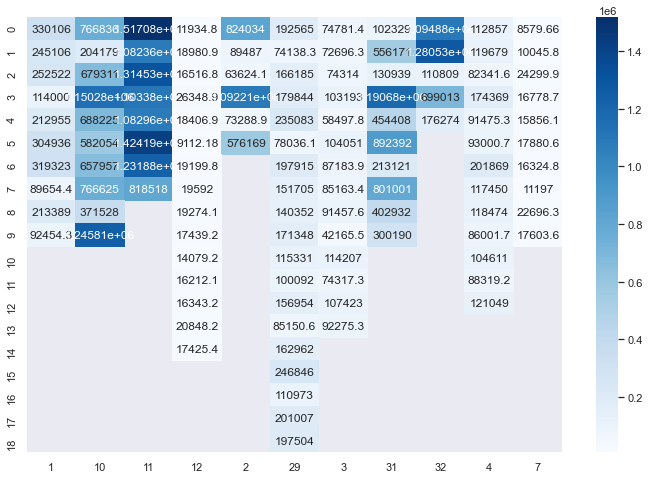

In [210]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12,8)})

df = pd.DataFrame(original_error)
g = sns.heatmap(df, cmap="Blues", annot=True, fmt='g')
g.get_figure().savefig("heatmap.png")

In [208]:
forecast_error = {key: {} for key in replaced}
sum_forecast_error = []
for site_id in replaced:
    for period_id in range(len(replaced[site_id])):
        for i in range(len(replaced[site_id][period_id])):
            if (len(replaced[site_id][period_id])-96 == i):
                break
            forecast_error[site_id][period_id] = np.sum(np.abs(replaced[site_id][period_id]['actual_consumption'][i+1:i+97]-replaced[site_id][period_id].iloc[i,5:5+96].values))
            sum_forecast_error.append(forecast_error[site_id][period_id])

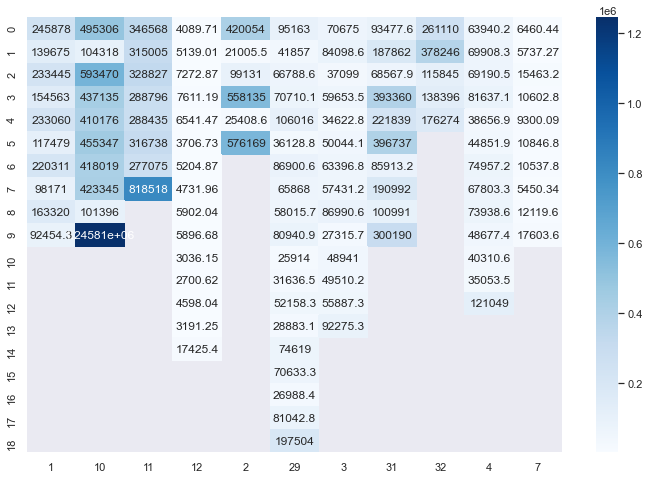

In [211]:
import seaborn as sns
sns.set(rc={"figure.figsize":(12,8)})

df = pd.DataFrame(forecast_error)
g = sns.heatmap(df, cmap="Blues", annot=True, fmt='g')
g.get_figure().savefig("heatmap.png")

In [209]:
(sum(sum_original_error)-sum(sum_forecast_error))/sum(sum_original_error)

0.5223236580974323

In [213]:
sum(sum_original_error)

141824389197.84708

In [212]:
sum(sum_forecast_error)

67746155424.593636

In [218]:
for site_id in replaced:    
    pd.concat(replaced[site_id]).to_csv('./Desktop/lgbtrained/linear/replpaced_{}.csv'.format(site_id))